In [1]:
# import module
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
import sys
import itertools
from scipy import stats
import pickle

# set directry
os.chdir('/Users/celerinoue/0_res/CTOS/')

In [2]:
def data_load(filename):
    data = pd.read_csv(filename)
    print(f'[LOAD]: {filename}')
    print(f'input matrix: {data.shape}')
    return data

CTOSdata_ = data_load("data/CTOS_result.csv")

[LOAD]: data/CTOS_result.csv
input matrix: (420, 13)


# day, value列の作成 dfの変換

**data_transform()**  
    - rawデータを変換する  
    - 出力はdata_val, pat_list, drug_listの3つ  

- data_val : LINE, 薬剤ごとのvalue　　
    - col : patient_id	drug_id	drug_name	subject_id	day	value  

- pat_list : 患者のリスト  
    - int 1~10 のLINEがある  

- drug_list : 薬剤のリスト
    - int 1~7
    - 1 : control
    - 2~7 : Oxaliplatin, Cetximab, Irinotecan


- l_gr : list og tumor growth rate  
    - 10(samples)-by-9(timepoint: 0, 4, 7, 11, 14, 18, 21, 25, 28)のtumor growth rate matrix

In [3]:
# Data Transforming
def data_transform(data):
    ## patient_id 4
    # 7.Irinotecan_10mg → Irinotecan_3mg, 8.Irinotecan_30mg → Irinotecan_10mg
    data[data["patient_id"] == 4] = data[data["patient_id"] == 4].replace({7:6, 8:7, 'Irinotecan_10mg':'Irinotecan_3mg', 'Irinotecan_30mg':'Irinotecan_10mg'})

    ## Convert all value to multiplier
    day_list = ["00", "04", "07", "11", "14", "18", "21", "25", "28"] 
    for l in day_list[1:]: # day list without 00
        data[l] = data[l] / data["00"] # multiplier
    data["00"] = 1  # day 00

    ## Transform the data format
    pat_list = data["patient_id"].drop_duplicates().tolist()  # patient_idの範囲
    drug_list = data["drug_id"].drop_duplicates().tolist()  # drug_idの範囲
    sub_list = data["subject_id"].drop_duplicates().tolist()  # subject_idの範囲
    l_ = []
    for pat, drg, sub in itertools.product(pat_list, drug_list, sub_list):
        data_row = data[(data['patient_id'] == pat) & (data['drug_id'] == drg) & (
        data['subject_id'] == sub)]  # Specify a column from data
        # define (day, value) from data
        value = data_row.iloc[:, 4:].T.reset_index()
        value.columns = ['day', 'value']  # column names of (day, value)
        # get index (patient_idm drug_id, drug_name, subject_id) from data
        index = data_row.iloc[:, :4].reset_index(drop=True)
        matrix = pd.concat([index, value], axis=1).fillna(method='ffill')
        l_.append(matrix)
    data_val = pd.concat(l_, axis=0).reset_index(drop=True)
    data_val = data_val.astype({'patient_id': int, 'drug_id': int, 'subject_id': int, 'day': int}) #intに変換
    
    # 薬剤の名前とIDのmatrix保存
    drug_index = data_val.drop_duplicates('drug_id').iloc[:,1:3].reset_index(drop=True)
    drug_index.to_csv('./result/matrix/drug_index.csv')

    #================
    # 7 matrix of tumor growth rate
    # 10(samples)-by-9(timepoint: 0, 4, 7, 11, 14, 18, 21, 25, 28)

    # (薬剤*全日程のtumor growth rate)のlistを作成 l_value
    l_value = []
    for l_drg, l_pat in itertools.product(drug_list, pat_list):
        l_ = data_val.query(f'(drug_id == {l_drg}) & (patient_id == {l_pat})').groupby('day')['value'].median().reset_index(drop=True)
        l_value.append(l_)
        #b = pd.DataFrame(l_value, index = pat_list)
        #l_df.append(b)

    # matrixに変換 
    l_value_ = list(np.array_split(l_value, 7)) # reshape the list
    l_gr = [] # list of tumor growth rates
    for i in drug_list:
        gr_ = pd.DataFrame(l_value_[i-1], index = pat_list, columns = day_list)
        l_gr.append(gr_)
    with open('./result/matrix/tumor_growth_rate.pickle', mode='wb') as f:
        pickle.dump(l_gr,f)
        f.close
    print(f'[SAVE]: list of tumor growth rates as tumor_growth_rate.pickle')


    #=================
    print('[INFO] TRANSFORMED THE DATA!!')
    print(f'data shape: {data_val.shape}')
    return data_val, pat_list, drug_list, day_list, drug_index, l_gr

CTOSdata, pat_list, drug_list, day_list, drug_index, l_gr = data_transform(CTOSdata_)

[SAVE]: list of tumor growth rates as tumor_growth_rate.pickle
[INFO] TRANSFORMED THE DATA!!
data shape: (3780, 6)


In [4]:
l_gr

[     00        04        07        11        14         18         21  \
 1   1.0  1.547643  2.028196  3.595589  4.696970   6.787550   7.726066   
 2   1.0  1.558217  2.989053  3.940194  5.032962   6.225101   7.647320   
 3   1.0  1.573750  1.975375  2.364869  2.649490   3.260622   3.510374   
 4   1.0  1.459680  1.525024  2.302090  2.884129   3.366409   3.849417   
 5   1.0  1.456042  1.747637  3.315327  4.142033   5.122954   5.531442   
 6   1.0  1.214966  1.737265  2.514891  3.025432   3.326536   3.903220   
 7   1.0  2.230417  3.606258  6.833981  9.135175  12.466242  13.950381   
 8   1.0  1.000000  2.130422  2.881409  3.496272   4.911727   5.859323   
 9   1.0  1.256147  1.515685  1.872214  2.460631   2.541457   2.980869   
 10  1.0  1.532335  2.303330  3.273000  3.597156   4.576221   5.520386   
 
            25         28  
 1    8.386095  10.895000  
 2    9.928000  11.628976  
 3    4.384727   5.463614  
 4    5.081306   5.426488  
 5    6.718536   8.213839  
 6    4.696812  

# matrix

- 10(samples)-by-9(timepoint: 0, 4, 7, 11, 14, 18, 21, 25, 28)のtumor growth rate matrix作成



# グラフの描画


[SAVE]: ./result/z_fig/mean_plot/fig_mean_ci_67_patient_6.png


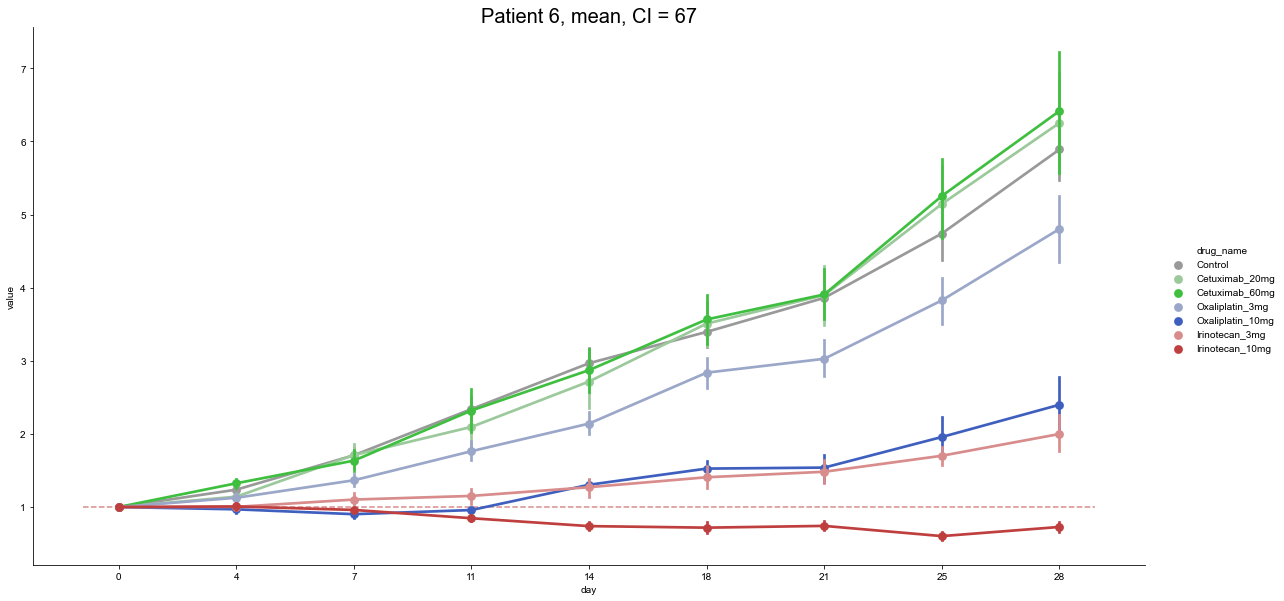

In [5]:
def fig_effects_per_patient(data, pat_num, estimator, ci):
    # option
    '''
    Args:
        data :
        pat_num : patient number [1~10]
        estimator : (optional) Statistical function to estimate [mean or median]
        ci : (optional) Size of confidence intervals to draw around estimated values [float or “sd”]
    '''
    #Args [estimator]
    if estimator == 'median':
        e = np.median
    else:
        estimator = 'mean'
        e = np.mean

    #Args [ci]
    if type(ci) is int:
        ci = ci
    else:
        ci = 'sd'

    #Args [data, pat_num]
    if type(pat_num) is int:
        data = data[data["patient_id"] == pat_num]
        pat_num = pat_num
        savepath = f'./result/z_fig/{estimator}_plot/fig_{estimator}_ci_{ci}_patient_{pat_num}.png'
    else:
        data = data
        pat_num = 'All [1~10]'
        savepath = f'./result/z_fig/{estimator}_plot/fig_{estimator}_ci_{ci}_patient_all.png'

    # (Cetuximab, Oxaliplatin, Irinotecan) = (green, blue, red)
    colorlist = ["#999999", "#9BC99B", "#3FBF3F",
                 "#9BA7C9", "#3F5FBF", "#D88C8C", "#BF3F3F"]
    sns.set_palette(colorlist, 7)
    #  Defaults are size=5, aspect=1
    sns.catplot(x='day', y='value', data=data, kind = 'point', hue='drug_name',
                   estimator=e, ci=ci, height=8, aspect=2)
    # supplementary wire [pink]
    plt.hlines(1, -0.3, 8.3, '#D88C8C', linestyles='dashed')
    sns.set_style("darkgrid", {'grid.linestyle': '--'})
    plt.title(f'Patient {pat_num}, {estimator}, CI = {ci}', fontsize=20)

    plt.savefig(savepath, dpi=300, format='png', bbox_inches="tight")
    print(f'[SAVE]: {savepath}')

fig_effects_per_patient(CTOSdata, 6, 'mean', 67)

[SAVE]: ./result/z_fig/mean_plot/fig_mean_ci_67_drug_Cetuximab_20mg.png


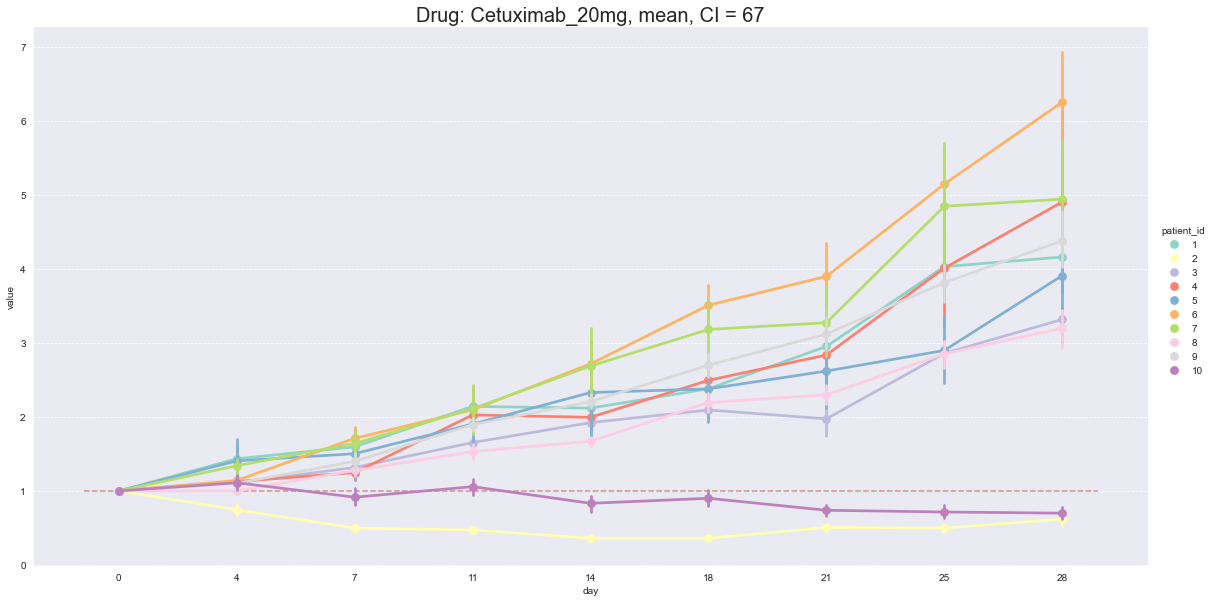

In [15]:
# 薬剤固定
def fig_effects_per_drug(data, drg_num, estimator, ci):
    #Args [estimator]
    if estimator == 'median':
        e = np.median
    else:
        estimator = 'mean'
        e = np.mean

    #Args [ci]
    if type(ci) is int:
        ci = ci
    else:
        ci = 'sd'

    #Args [data, drg_num]
    if type(drg_num) is int:
        data = data[data["drug_id"] == drg_num]
        drg_name = data[data["drug_id"] == drg_num]["drug_name"].iloc[1]
        savepath = f'./result/z_fig/{estimator}_plot/fig_{estimator}_ci_{ci}_drug_{drg_name}.png'
    else:
        data = data
        drg_name = 'All [1~10]'
        savepath = f'./result/z_fig/{estimator}_plot/fig_{estimator}_ci_{ci}_drug_all.png'

    sns.set_palette('Set3')
    sns.catplot(x='day', y='value', data=data, kind='point', hue='patient_id', estimator=e, ci=ci, height=8, aspect=2)
    #  Defaults are size=5, aspect=1
    plt.hlines(1, -0.3, 8.3, '#D88C8C', linestyles='dashed')  # 補助線
    sns.set_style("darkgrid", {'grid.linestyle': '--'})
    plt.title(f'Drug: {drg_name}, {estimator}, CI = {ci}', fontsize=20)

    plt.savefig(savepath, dpi=300, format='png', bbox_inches="tight")
    print(f'[SAVE]: {savepath}')

fig_effects_per_drug(data_val, 2, 'mean', 67)

# t-test

In [6]:
def cal_pvalue(data, path):
    # make list
    pat_list = data["patient_id"].drop_duplicates().tolist()  # patient_idの範囲
    drg_list = data["drug_id"].drop_duplicates().tolist()  # drug_idの範囲
    drg_name_list = data["drug_name"].drop_duplicates().tolist()
    day_list = data["day"].drop_duplicates().tolist()
    day_list.remove(0)  # drop '0' day

    # prepare dataset to calculate p-value
    list_t = []
    for pat, day, drg in itertools.product(pat_list, day_list, drg_list):
        v = data[(data['patient_id'] == pat) & (data['day'] == day)
                 & (data['drug_id'] == drg)]['value']
        list_t.append(v)
        a = np.array(list_t)
    data_reshape = a.reshape([80, 7, 6])

    # calculate p-value
    list_p = []
    for m in range(0, 80):
        for l in range(1, 7):  # t-testの回数
            p = stats.ttest_rel(data_reshape[m][0], data_reshape[m][l])[1]
            list_p.append(p)
    data_pval_p = pd.DataFrame(np.reshape(
        list_p, (80, 6)), columns=drg_name_list[1:7])

    # make dataframe drug_name
    data_pval_f = data[["patient_id", "day"]].drop_duplicates()
    data_pval_f = data_pval_f[data_pval_f['day'] != 0].reset_index(drop=True)

    data_pval = pd.concat([data_pval_f, data_pval_p], axis=1)
    data_pval.to_csv(path)
    print(f'[SAVE]: {path}')
    return


cal_pvalue(CTOSdata, "./result/matrix/p_value.csv")

[SAVE]: ./result/matrix/p_value.csv
